<a href="https://www.kaggle.com/code/mesutssmn/electricity-price-prediction?scriptVersionId=170851109" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [2]:
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
df = pd.read_csv("/kaggle/input/electricity-price-prediction/Electricity.csv",low_memory=False)

In [4]:
def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(3))
    print("##################### Tail #####################")
    print(dataframe.tail(3))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    numeric_columns = dataframe.select_dtypes(include=['number']).columns
    print(dataframe[numeric_columns].quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [5]:
check_df(df)

##################### Shape #####################
(38014, 18)
##################### Types #####################
DateTime                  object
Holiday                   object
HolidayFlag                int64
DayOfWeek                  int64
WeekOfYear                 int64
Day                        int64
Month                      int64
Year                       int64
PeriodOfDay                int64
ForecastWindProduction    object
SystemLoadEA              object
SMPEA                     object
ORKTemperature            object
ORKWindspeed              object
CO2Intensity              object
ActualWindProduction      object
SystemLoadEP2             object
SMPEP2                    object
dtype: object
##################### Head #####################
           DateTime Holiday  HolidayFlag  DayOfWeek  WeekOfYear  Day  Month  \
0  01/11/2011 00:00     NaN            0          1          44    1     11   
1  01/11/2011 00:30     NaN            0          1          44    1     

In [6]:
df.head()

,DateTime,Holiday,HolidayFlag,DayOfWeek,WeekOfYear,Day,Month,Year,PeriodOfDay,ForecastWindProduction,SystemLoadEA,SMPEA,ORKTemperature,ORKWindspeed,CO2Intensity,ActualWindProduction,SystemLoadEP2,SMPEP2
0,01/11/2011 00:00,NaN,0,1,44,1,11,2011,0,315.31,3388.77,49.26,6.00,9.30,600.71,356.00,3159.60,54.32
1,01/11/2011 00:30,NaN,0,1,44,1,11,2011,1,321.80,3196.66,49.26,6.00,11.10,605.42,317.00,2973.01,54.23
2,01/11/2011 01:00,NaN,0,1,44,1,11,2011,2,328.57,3060.71,49.10,5.00,11.10,589.97,311.00,2834.00,54.23
3,01/11/2011 01:30,NaN,0,1,44,1,11,2011,3,335.60,2945.56,48.04,6.00,9.30,585.94,313.00,2725.99,53.47
4,01/11/2011 02:00,NaN,0,1,44,1,11,2011,4,342.90,2849.34,33.75,6.00,11.10,571.52,346.00,2655.64,39.87


In [7]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
  
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, cat_but_car, num_cols

In [8]:
cat_cols, cat_but_car, num_cols = grab_col_names(df)

Observations: 38014
Variables: 18
cat_cols: 4
num_cols: 4
cat_but_car: 10
num_but_cat: 3


                      Holiday  Ratio
Holiday                             
Christmas Eve             144  0.379
Christmas                 144  0.379
St Stephen's Day          144  0.379
New Year's Eve            144  0.379
New Year's Day             96  0.253
St Patrick's Day           96  0.253
Good Friday                96  0.253
Holy Saturday              96  0.253
Easter                     96  0.253
Easter Monday              96  0.253
May Day                    96  0.253
June Bank Holiday          96  0.253
August Bank Holiday        96  0.253
October Bank Holiday       96  0.253


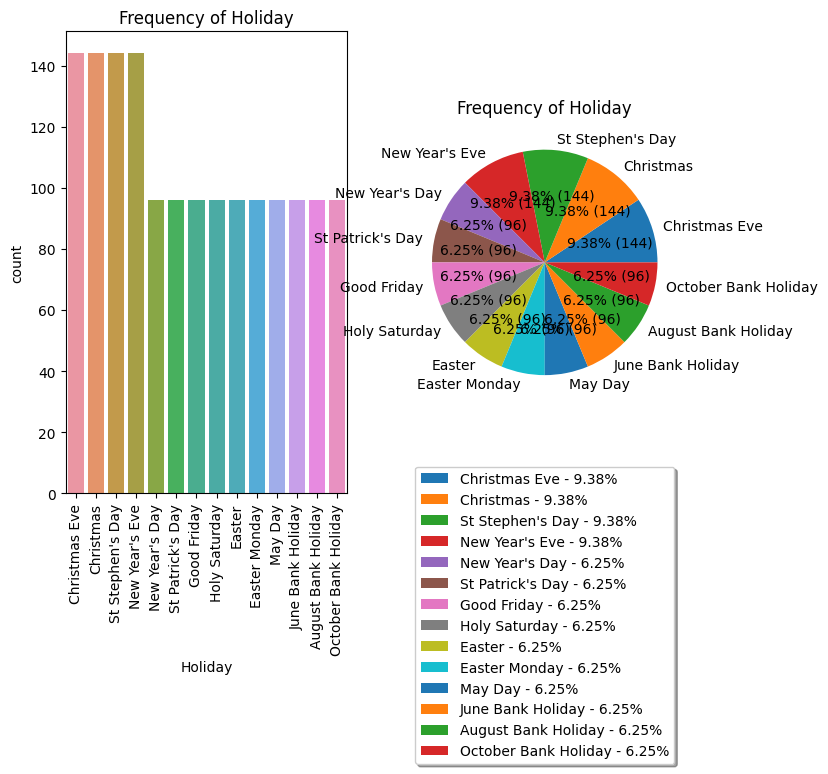

             HolidayFlag  Ratio
HolidayFlag                    
0                  36478 95.959
1                   1536  4.041


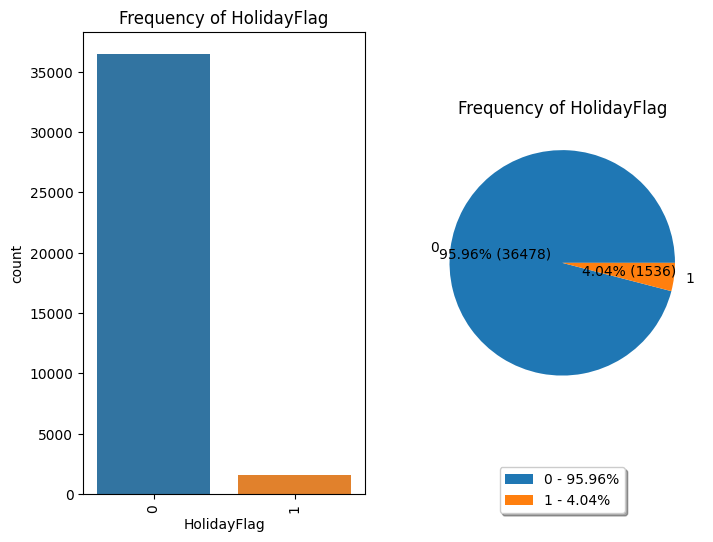

           DayOfWeek  Ratio
DayOfWeek                  
1               5472 14.395
2               5424 14.268
3               5424 14.268
4               5424 14.268
5               5424 14.268
0               5424 14.268
6               5422 14.263


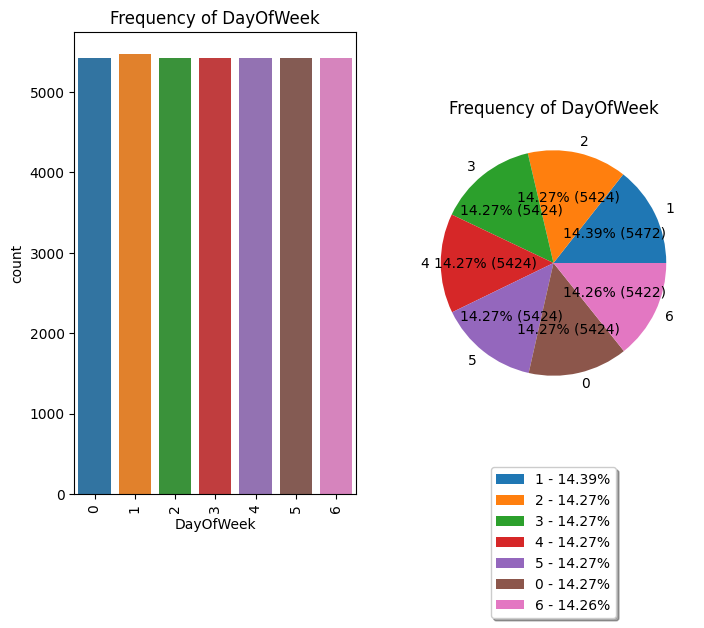

       Year  Ratio
Year              
2012  17566 46.209
2013  17520 46.088
2011   2928  7.702


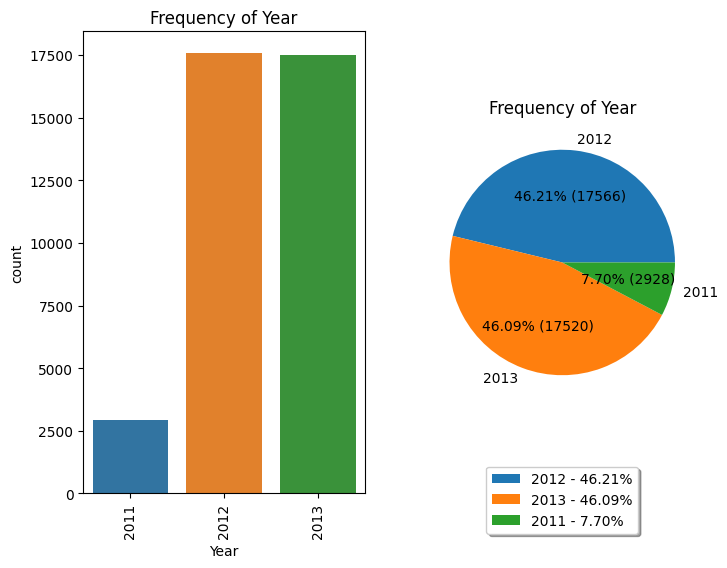

In [9]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))

    if plot:
        fig, axs = plt.subplots(1, 2, figsize=(8, 6))
        plt.subplot(1, 2, 1)
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.title("Frequency of " + col_name)
        plt.xticks(rotation=90)

        plt.subplot(1, 2, 2)
        values = dataframe[col_name].value_counts()
        plt.pie(x=values, labels=values.index, autopct=lambda p: '{:.2f}% ({:.0f})'.format(p, p/100 * sum(values)))
        plt.title("Frequency of " + col_name)
        plt.legend(labels=['{} - {:.2f}%'.format(index, value/sum(values)*100) for index, value in zip(values.index, values)],
                   loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=1)
        plt.show(block=True)

for col in cat_cols:
    cat_summary(df, col, True)

In [10]:
df[num_cols]

,WeekOfYear,Day,Month,PeriodOfDay
0,44,1,11,0
1,44,1,11,1
2,44,1,11,2
3,44,1,11,3
4,44,1,11,4
...,...,...,...,...
38009,1,31,12,43
38010,1,31,12,44
38011,1,31,12,45
38012,1,31,12,46


In [11]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

for col in num_cols:
    target_summary_with_num(df, "SMPEP2", col)

        WeekOfYear
SMPEP2            
-3.50       51.000
-47.74       1.000
0.00        38.304
0.03        33.000
1.07        49.000
...            ...
99.95       28.000
99.96       34.000
99.97       19.000
99.99       49.000
?           13.000

[7814 rows x 1 columns]


          Day
SMPEP2       
-3.50  19.000
-47.74  5.000
0.00   12.652
0.03   17.000
1.07    5.000
...       ...
99.95  11.500
99.96  22.000
99.97  10.000
99.99   6.000
?      31.000

[7814 rows x 1 columns]


        Month
SMPEP2       
-3.50  12.000
-47.74  1.000
0.00    9.348
0.03    8.000
1.07   12.000
...       ...
99.95   7.000
99.96   8.000
99.97   5.000
99.99  12.000
?       3.000

[7814 rows x 1 columns]


        PeriodOfDay
SMPEP2             
-3.50         4.500
-47.74       11.000
0.00          8.696
0.03         11.000
1.07          7.000
...             ...
99.95        38.000
99.96        18.000
99.97        36.000
99.99        32.000
?             2.500

[7814 rows x 1 columns]




In [12]:
df["Holiday"].unique()

array([nan, 'Christmas Eve', 'Christmas', "St Stephen's Day",
       "New Year's Eve", "New Year's Day", "St Patrick's Day",
       'Good Friday', 'Holy Saturday', 'Easter', 'Easter Monday',
       'May Day', 'June Bank Holiday', 'August Bank Holiday',
       'October Bank Holiday'], dtype=object)

In [13]:
df['Holiday'].fillna('Not a holiday', inplace=True)

In [14]:
df.replace("?", float("nan"), inplace=True)

In [15]:
df[df.values == "?"]

,DateTime,Holiday,HolidayFlag,DayOfWeek,WeekOfYear,Day,Month,Year,PeriodOfDay,ForecastWindProduction,SystemLoadEA,SMPEA,ORKTemperature,ORKWindspeed,CO2Intensity,ActualWindProduction,SystemLoadEP2,SMPEP2


In [16]:
df.isna().sum()

DateTime                    0
Holiday                     0
HolidayFlag                 0
DayOfWeek                   0
WeekOfYear                  0
Day                         0
Month                       0
Year                        0
PeriodOfDay                 0
ForecastWindProduction      5
SystemLoadEA                2
SMPEA                       2
ORKTemperature            295
ORKWindspeed              299
CO2Intensity                7
ActualWindProduction        5
SystemLoadEP2               2
SMPEP2                      2
dtype: int64

In [17]:
def outlier_thresholds(dataframe, variable, low_quantile=0.05, up_quantile=0.95):
    quantile_one = dataframe[variable].quantile(low_quantile)
    quantile_three = dataframe[variable].quantile(up_quantile)
    interquantile_range = quantile_three - quantile_one
    up_limit = quantile_three + 1.5 * interquantile_range
    low_limit = quantile_one - 1.5 * interquantile_range
    return low_limit, up_limit

In [18]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [19]:
for col in num_cols:
    if col != "SMPEP2":
      print(col, check_outlier(df, col))

WeekOfYear False
Day False
Month False
PeriodOfDay False


In [20]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [21]:
for col in num_cols:
    if col != "SMPEP2":
        replace_with_thresholds(df,col)

In [22]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)

    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)

    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])

    print(missing_df, end="\n")

    if na_name:
        return na_columns

In [23]:
missing_values_table(df)

                        n_miss  ratio
ORKWindspeed               299  0.790
ORKTemperature             295  0.780
CO2Intensity                 7  0.020
ForecastWindProduction       5  0.010
ActualWindProduction         5  0.010
SystemLoadEA                 2  0.010
SMPEA                        2  0.010
SystemLoadEP2                2  0.010
SMPEP2                       2  0.010


In [24]:
for col in df.columns:
    if df[col].isna().any():
        df[col] = pd.to_numeric(df[col], errors='coerce')
        col_mean = df[col].mean()
        df[col].fillna(col_mean, inplace=True)

In [25]:
df.head()

,DateTime,Holiday,HolidayFlag,DayOfWeek,WeekOfYear,Day,Month,Year,PeriodOfDay,ForecastWindProduction,SystemLoadEA,SMPEA,ORKTemperature,ORKWindspeed,CO2Intensity,ActualWindProduction,SystemLoadEP2,SMPEP2
0,01/11/2011 00:00,Not a holiday,0,1,44,1.000,11.000,2011,0.000,315.310,3388.770,49.260,6.000,9.300,600.710,356.000,3159.600,54.320
1,01/11/2011 00:30,Not a holiday,0,1,44,1.000,11.000,2011,1.000,321.800,3196.660,49.260,6.000,11.100,605.420,317.000,2973.010,54.230
2,01/11/2011 01:00,Not a holiday,0,1,44,1.000,11.000,2011,2.000,328.570,3060.710,49.100,5.000,11.100,589.970,311.000,2834.000,54.230
3,01/11/2011 01:30,Not a holiday,0,1,44,1.000,11.000,2011,3.000,335.600,2945.560,48.040,6.000,9.300,585.940,313.000,2725.990,53.470
4,01/11/2011 02:00,Not a holiday,0,1,44,1.000,11.000,2011,4.000,342.900,2849.340,33.750,6.000,11.100,571.520,346.000,2655.640,39.870


In [26]:
missing_values_table(df)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


In [27]:
df['ORKTemperature'] = pd.to_numeric(df['ORKTemperature'], errors='coerce')

df['TemperatureCategory'] = pd.cut(df['ORKTemperature'], bins=[-np.inf, 10, 20, np.inf], labels=['Cold', 'Moderate', 'Hot'])
df['DateTime'] = pd.to_datetime(df['DateTime'], format='%d/%m/%Y %H:%M')
df['DateTime'] = pd.to_datetime(df['DateTime'])
df['Hour'] = df['DateTime'].dt.hour
df['DayOfWeek'] = df['DateTime'].dt.dayofweek
df['Month'] = df['DateTime'].dt.month

holiday_columns = [col for col in df.columns if col.startswith('Holiday_')]
df['IsHoliday'] = df[holiday_columns].any(axis=1).astype(int)
df['Temperature_Windspeed'] = df['ORKTemperature'] * df['ORKWindspeed']
df['Load_EA_Production'] = df['SystemLoadEA'] / df['ActualWindProduction']

df['Temperature_RollingMean'] = df['ORKTemperature'].rolling(window=24, min_periods=1).mean()
df['Load_EA_Std'] = df['SystemLoadEA'].rolling(window=24, min_periods=1).std()  # 24-hour rolling standard deviation

df['IsWeekend'] = df['DateTime'].dt.dayofweek.isin([5, 6]).astype(int)  # 5 and 6 represent Saturday and Sunday
df['Daytime'] = df['DateTime'].dt.hour.between(6, 18).astype(int)  # Daytime between 6 AM and 6 PM

df['Hour_sin'] = np.sin(2 * np.pi * df['DateTime'].dt.hour / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['DateTime'].dt.hour / 24)
df['Month_sin'] = np.sin(2 * np.pi * df['DateTime'].dt.month / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['DateTime'].dt.month / 12)

In [28]:
df.head()

,DateTime,Holiday,HolidayFlag,DayOfWeek,WeekOfYear,Day,Month,Year,PeriodOfDay,ForecastWindProduction,SystemLoadEA,SMPEA,ORKTemperature,ORKWindspeed,CO2Intensity,ActualWindProduction,SystemLoadEP2,SMPEP2,TemperatureCategory,Hour,IsHoliday,Temperature_Windspeed,Load_EA_Production,Temperature_RollingMean,Load_EA_Std,IsWeekend,Daytime,Hour_sin,Hour_cos,Month_sin,Month_cos
0,2011-11-01 00:00:00,Not a holiday,0,1,44,1.000,11,2011,0.000,315.310,3388.770,49.260,6.000,9.300,600.710,356.000,3159.600,54.320,Cold,0,0,55.800,9.519,6.000,NaN,0,0,0.000,1.000,-0.500,0.866
1,2011-11-01 00:30:00,Not a holiday,0,1,44,1.000,11,2011,1.000,321.800,3196.660,49.260,6.000,11.100,605.420,317.000,2973.010,54.230,Cold,0,0,66.600,10.084,6.000,135.842,0,0,0.000,1.000,-0.500,0.866
2,2011-11-01 01:00:00,Not a holiday,0,1,44,1.000,11,2011,2.000,328.570,3060.710,49.100,5.000,11.100,589.970,311.000,2834.000,54.230,Cold,1,0,55.500,9.842,5.667,164.829,0,0,0.259,0.966,-0.500,0.866
3,2011-11-01 01:30:00,Not a holiday,0,1,44,1.000,11,2011,3.000,335.600,2945.560,48.040,6.000,9.300,585.940,313.000,2725.990,53.470,Cold,1,0,55.800,9.411,5.750,190.560,0,0,0.259,0.966,-0.500,0.866
4,2011-11-01 02:00:00,Not a holiday,0,1,44,1.000,11,2011,4.000,342.900,2849.340,33.750,6.000,11.100,571.520,346.000,2655.640,39.870,Cold,2,0,66.600,8.235,5.800,212.286,0,0,0.500,0.866,-0.500,0.866


In [29]:
df["Load_EA_Std"].fillna(df["Load_EA_Std"].mean(), inplace=True)

In [30]:
target_column = df['SMPEP2']
df.drop("SMPEP2", axis=1, inplace=True)

In [31]:
cat_cols, cat_but_car, num_cols = grab_col_names(df)

def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

Observations: 38014
Variables: 30
cat_cols: 8
num_cols: 22
cat_but_car: 0
num_but_cat: 7


In [32]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe
dfd = one_hot_encoder(df, cat_cols, drop_first=True)

In [33]:
binary_cols = [col for col in dfd.columns if dfd[col].dtypes == "O" and len(dfd[col].unique()) == 2]

for col in binary_cols:
    label_encoder(dfd, col)

In [34]:
binary_cols

[]

In [35]:
dfd = pd.concat([dfd, target_column], axis=1)

In [36]:
for i in dfd.columns:
    if dfd[i].dtype == bool:  
        dfd[i] = dfd[i].astype(int) 

In [37]:
dfd["ForecastWindProduction"] = pd.to_numeric(dfd["ForecastWindProduction"], errors='coerce')
dfd["ForecastWindProduction"] = dfd["ForecastWindProduction"].astype(float)
dfd["SMPEA"] = dfd["SMPEA"].astype(float) 
dfd["CO2Intensity"] = dfd["CO2Intensity"].astype(float) 
dfd["SystemLoadEP2"] = dfd["SystemLoadEP2"].astype(float) 
dfd["SMPEP2"] = dfd["SMPEP2"].astype(float)
dfd["Day"] = dfd["Day"].astype(int)
dfd["PeriodOfDay"] = dfd["PeriodOfDay"].astype(int)

In [38]:
dfd.head()

,DateTime,WeekOfYear,Day,Month,PeriodOfDay,ForecastWindProduction,SystemLoadEA,SMPEA,ORKTemperature,ORKWindspeed,CO2Intensity,ActualWindProduction,SystemLoadEP2,Hour,Temperature_Windspeed,Load_EA_Production,Temperature_RollingMean,Load_EA_Std,Hour_sin,Hour_cos,Month_sin,Month_cos,Holiday_Christmas,Holiday_Christmas Eve,Holiday_Easter,Holiday_Easter Monday,Holiday_Good Friday,Holiday_Holy Saturday,Holiday_June Bank Holiday,Holiday_May Day,Holiday_New Year's Day,Holiday_New Year's Eve,Holiday_Not a holiday,Holiday_October Bank Holiday,Holiday_St Patrick's Day,Holiday_St Stephen's Day,HolidayFlag_1,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,Year_2012,Year_2013,TemperatureCategory_Moderate,TemperatureCategory_Hot,IsWeekend_1,Daytime_1,SMPEP2
0,2011-11-01 00:00:00,44,1,11,0,315.310,3388.770,49.260,6.000,9.300,600.710,356.000,3159.600,0,55.800,9.519,6.000,584.116,0.000,1.000,-0.500,0.866,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,54.320
1,2011-11-01 00:30:00,44,1,11,1,321.800,3196.660,49.260,6.000,11.100,605.420,317.000,2973.010,0,66.600,10.084,6.000,135.842,0.000,1.000,-0.500,0.866,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,54.230
2,2011-11-01 01:00:00,44,1,11,2,328.570,3060.710,49.100,5.000,11.100,589.970,311.000,2834.000,1,55.500,9.842,5.667,164.829,0.259,0.966,-0.500,0.866,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,54.230
3,2011-11-01 01:30:00,44,1,11,3,335.600,2945.560,48.040,6.000,9.300,585.940,313.000,2725.990,1,55.800,9.411,5.750,190.560,0.259,0.966,-0.500,0.866,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,53.470
4,2011-11-01 02:00:00,44,1,11,4,342.900,2849.340,33.750,6.000,11.100,571.520,346.000,2655.640,2,66.600,8.235,5.800,212.286,0.500,0.866,-0.500,0.866,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,39.870


<Axes: >

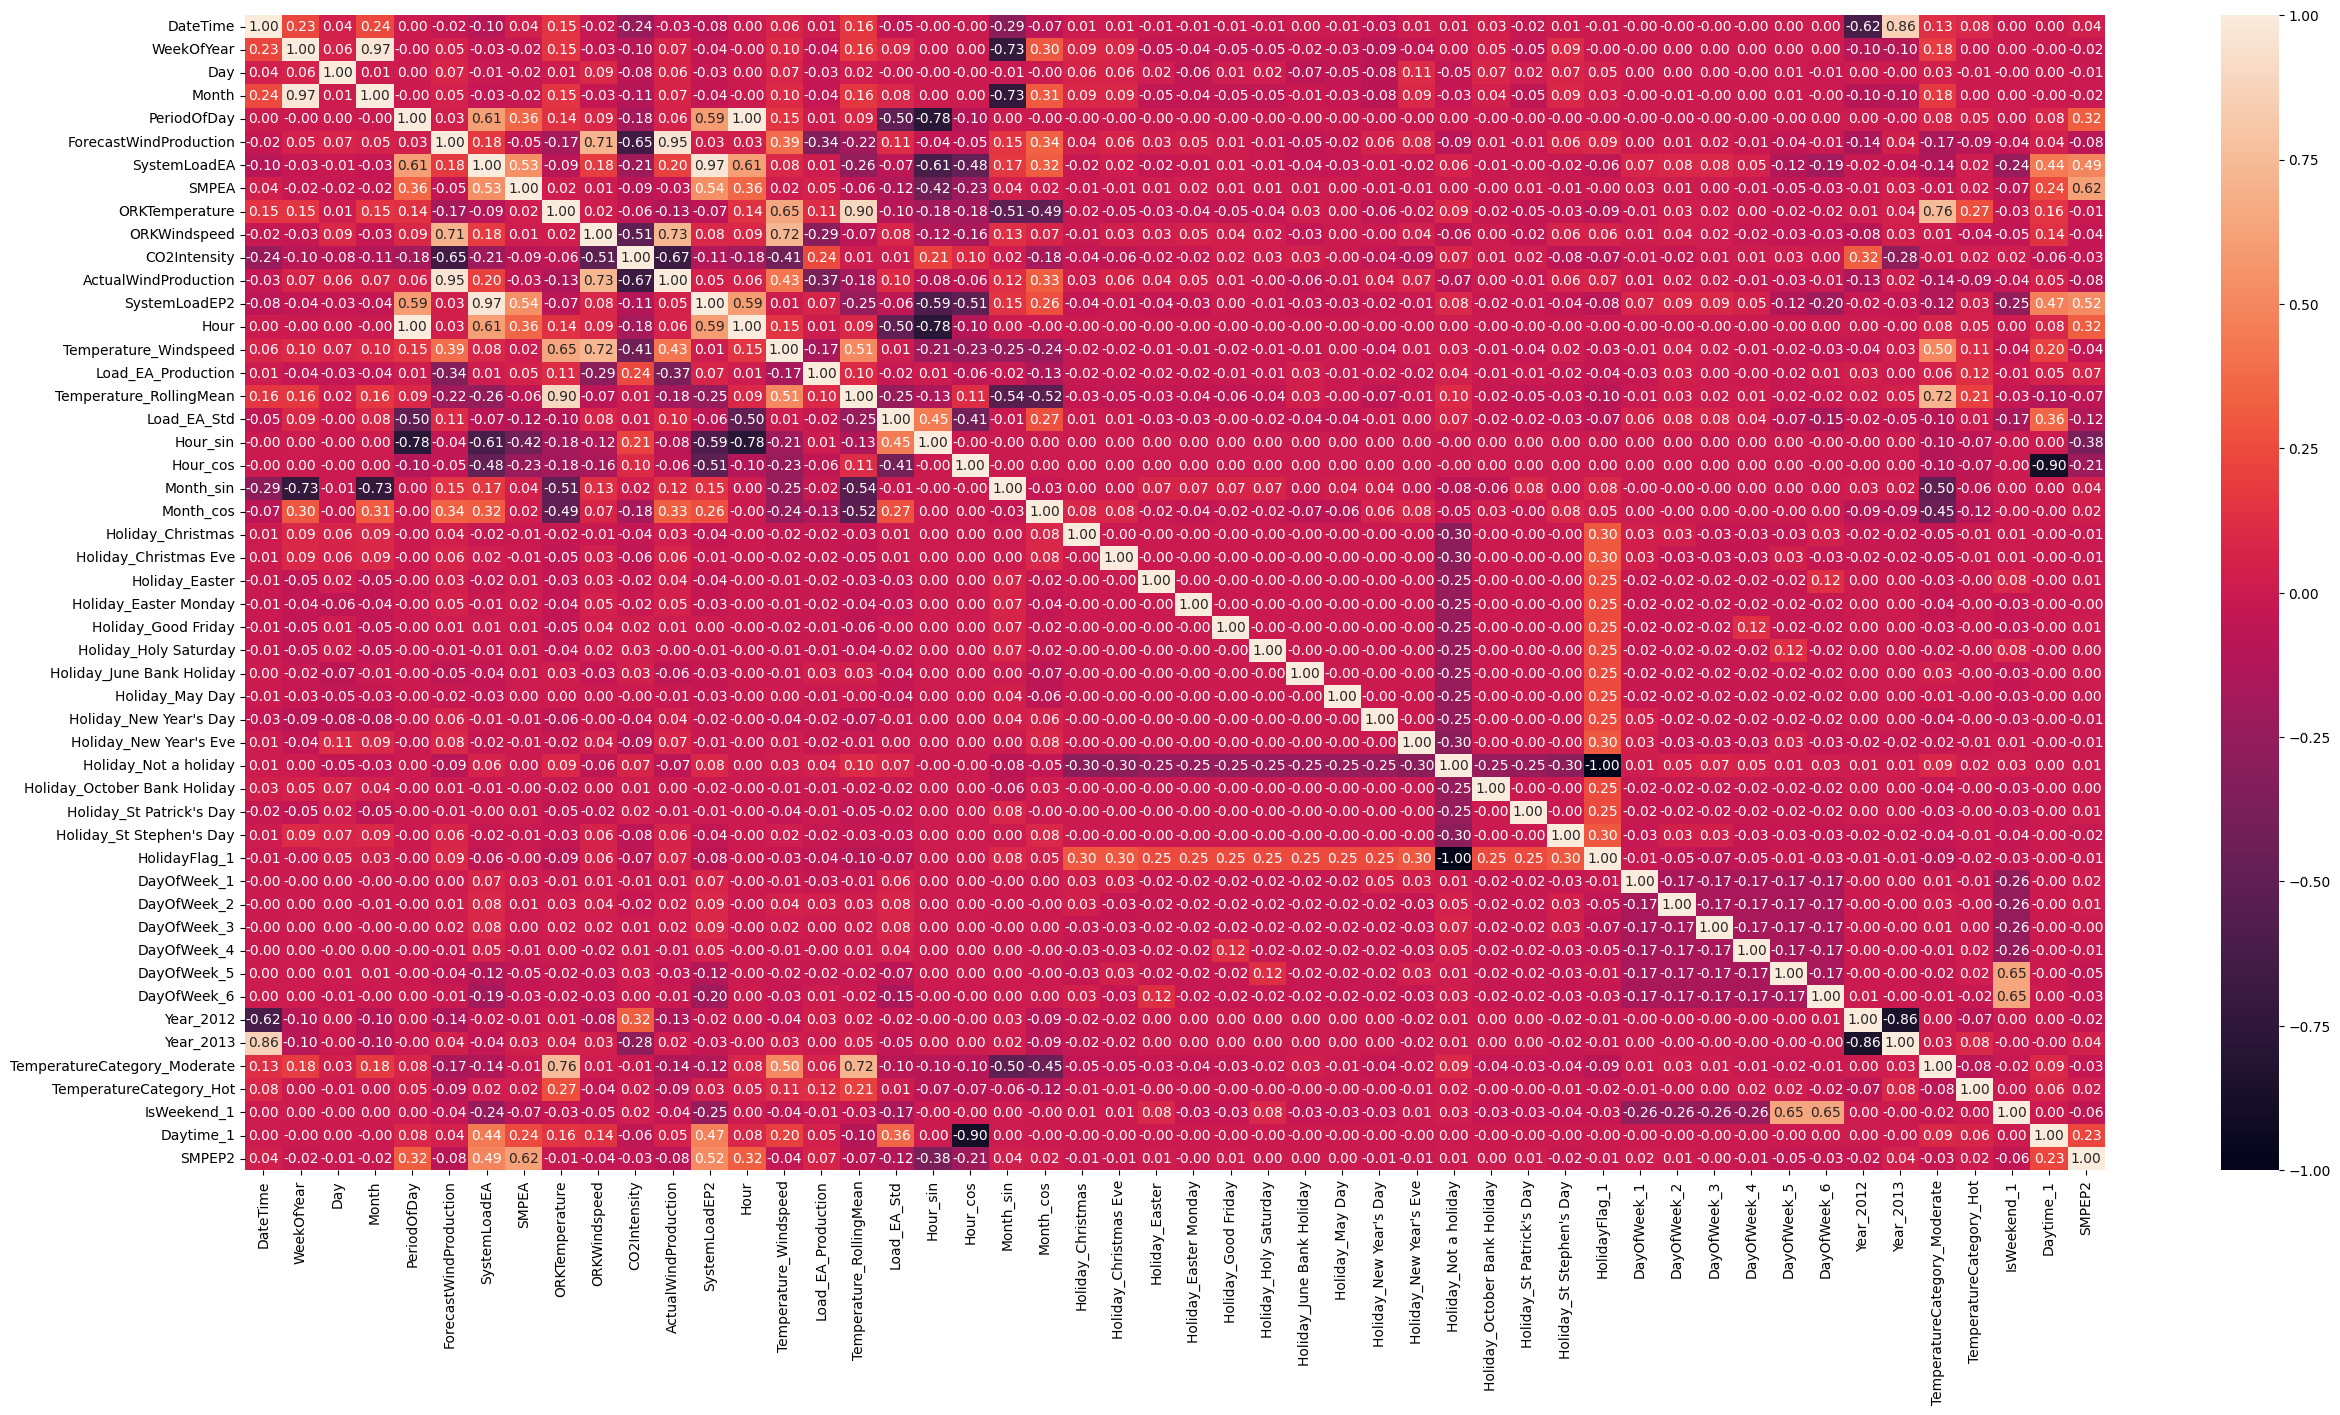

In [39]:
plt.figure(figsize=(30,15))
sns.heatmap(dfd.corr(), annot=True, fmt=".2f")

In [40]:
y_try = dfd["SMPEP2"]
X_try = dfd.drop(["SMPEP2","DateTime"], axis=1)
X_train_try, X_test_try, y_train_try, y_test_try = train_test_split(X_try, y_try, test_size=0.25, random_state=42)

rf_model = RandomForestRegressor(random_state=42).fit(X_train_try, y_train_try)
y_pred = rf_model.predict(X_test_try)

In [41]:
rf_model.score(X_test_try, y_test_try)

0.626766139132376

In [42]:
y = dfd["SMPEP2"]
X = dfd.drop(["SMPEP2","DateTime"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [43]:
X

,WeekOfYear,Day,Month,PeriodOfDay,ForecastWindProduction,SystemLoadEA,SMPEA,ORKTemperature,ORKWindspeed,CO2Intensity,ActualWindProduction,SystemLoadEP2,Hour,Temperature_Windspeed,Load_EA_Production,Temperature_RollingMean,Load_EA_Std,Hour_sin,Hour_cos,Month_sin,Month_cos,Holiday_Christmas,Holiday_Christmas Eve,Holiday_Easter,Holiday_Easter Monday,Holiday_Good Friday,Holiday_Holy Saturday,Holiday_June Bank Holiday,Holiday_May Day,Holiday_New Year's Day,Holiday_New Year's Eve,Holiday_Not a holiday,Holiday_October Bank Holiday,Holiday_St Patrick's Day,Holiday_St Stephen's Day,HolidayFlag_1,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,Year_2012,Year_2013,TemperatureCategory_Moderate,TemperatureCategory_Hot,IsWeekend_1,Daytime_1
0,44,1,11,0,315.310,3388.770,49.260,6.000,9.300,600.710,356.000,3159.600,0,55.800,9.519,6.000,584.116,0.000,1.000,-0.500,0.866,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,44,1,11,1,321.800,3196.660,49.260,6.000,11.100,605.420,317.000,2973.010,0,66.600,10.084,6.000,135.842,0.000,1.000,-0.500,0.866,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,44,1,11,2,328.570,3060.710,49.100,5.000,11.100,589.970,311.000,2834.000,1,55.500,9.842,5.667,164.829,0.259,0.966,-0.500,0.866,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,44,1,11,3,335.600,2945.560,48.040,6.000,9.300,585.940,313.000,2725.990,1,55.800,9.411,5.750,190.560,0.259,0.966,-0.500,0.866,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,44,1,11,4,342.900,2849.340,33.750,6.000,11.100,571.520,346.000,2655.640,2,66.600,8.235,5.800,212.286,0.500,0.866,-0.500,0.866,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38009,1,31,12,43,1179.140,3932.220,34.510,6.000,22.200,285.310,812.000,3692.950,21,133.200,4.843,5.417,180.120,-0.707,0.707,-0.000,1.000,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0
38010,1,31,12,44,1152.010,3821.440,33.830,5.000,24.100,278.310,852.000,3571.000,22,120.500,4.485,5.458,189.793,-0.500,0.866,-0.000,1.000,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0
38011,1,31,12,45,1123.670,3724.210,31.750,4.000,20.400,280.910,962.000,3460.290,22,81.600,3.871,5.375,214.693,-0.500,0.866,-0.000,1.000,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0
38012,1,31,12,46,1094.240,3638.160,33.830,5.000,14.800,302.460,950.000,3563.990,23,74.000,3.830,5.375,245.710,-0.259,0.966,-0.000,1.000,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0


In [44]:
models = [('LR', LinearRegression()),
          ('KNN', KNeighborsRegressor()),
          ('CART', DecisionTreeRegressor()),
          ('RF', RandomForestRegressor(n_estimators=200)),
          ('SVC', SVR()),
          ('GBM', GradientBoostingRegressor(n_estimators=200, learning_rate=0.06)),
          ("XGBoost", XGBRegressor(learning_rate=0.06)),
          ("LightGBM", LGBMRegressor(learning_rate=0.06, verbose=-1)),
          ("CatBoost", CatBoostRegressor(learning_rate=0.06,verbose=False))]

In [45]:
lgb_model = LGBMRegressor(verbose=-1, random_state=42)
lgb_params = {"learning_rate": [0.01, 0.02, 0.03,0.04, 0.06, 0.08, 0.1],
               "n_estimators": [300, 400, 600, 1200, 1500]}
lgb_gs_best = GridSearchCV(lgb_model,
                            lgb_params,
                            cv=3,
                            n_jobs=-1,
                            verbose=False).fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current versio

In [46]:
lgb_gs_best.best_params_

{'learning_rate': 0.08, 'n_estimators': 1500}

In [47]:
final_lgb = lgb_model.set_params(**lgb_gs_best.best_params_).fit(X_train, y_train)

In [48]:
final_lgb.score(X_test,y_test)

0.6348798663098978

In [49]:
y_pred_lgb = final_lgb.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred_lgb)
print("Mean Squared Error:", mse)

Mean Squared Error: 425.7303943606865


In [50]:
cat_model = CatBoostRegressor(verbose=False, random_state=42)
cat_params = {"learning_rate": [0.01, 0.02, 0.03,0.04, 0.06, 0.08, 0.1],
               "n_estimators": [300, 400, 600, 1200, 1500]}
cat_gs_best = GridSearchCV(cat_model,
                            cat_params,
                            cv=3,
                            n_jobs=-1,
                            verbose=False).fit(X_train, y_train)

In [51]:
cat_gs_best.best_params_

{'learning_rate': 0.1, 'n_estimators': 1500}

In [52]:
final_cat = cat_model.set_params(**lgb_gs_best.best_params_).fit(X_train, y_train)

In [53]:
final_cat.score(X_test,y_test)

0.6084791755973193

In [54]:
y_pred_cat = final_cat.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred_cat)
print("Mean Squared Error:", mse)

Mean Squared Error: 456.5136227596992


# ANN

In [55]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization

2024-04-07 18:40:25.912407: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-07 18:40:25.912512: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-07 18:40:26.073566: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [56]:
#X=np.asarray(X_train).astype(np.float32)
#Y=np.asarray(y_train).astype(np.float32)

In [57]:
X_train.shape

(28510, 48)

In [58]:
import tensorflow as tf
from tensorflow.keras import layers, Model

class ResidualBlock(layers.Layer):
    def __init__(self, units):
        super(ResidualBlock, self).__init__()
        self.dense1 = layers.Dense(units, activation='relu')
        self.dense2 = layers.Dense(units)
    
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return layers.add([inputs, x])

class ResidualANN(Model):
    def __init__(self):
        super(ResidualANN, self).__init__()
        self.dense1 = layers.Dense(64, activation='relu')
        self.residual_block1 = ResidualBlock(64)
        self.dense1 = layers.Dense(64, activation='relu')
        self.residual_block1 = ResidualBlock(64)
        self.dense1 = layers.Dense(64, activation='relu')
        self.residual_block1 = ResidualBlock(64)
        self.dense2 = layers.Dense(64, activation='relu')
        self.residual_block2 = ResidualBlock(64)
        self.dense3 = layers.Dense(1) 
    
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.residual_block1(x)
        x = self.dense2(x)
        x = self.residual_block2(x)
        return self.dense3(x)

model = ResidualANN()

model.compile(optimizer='adam', loss='mse')

early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True)
model.summary()

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)


Model: "residual_ann"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block (ResidualBlock)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_1                │ ?                      │   0 (unbuilt) │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_2                │ ?                      │   0 (unbuilt) │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_3                │ ?                      │   0 (unbuilt) │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:359: UserWarning: `build()` was called on layer 'residual_ann', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


 91/713 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 117297.1484

I0000 00:00:1712515241.781608     772 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


713/713 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 24650.9004 - val_loss: 955.7993
Epoch 2/100
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1042.4277 - val_loss: 1216.6781
Epoch 3/100
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 880.8553 - val_loss: 706.5104
Epoch 4/100
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 945.4716 - val_loss: 730.2228
Epoch 5/100
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 790.1019 - val_loss: 713.3363
Epoch 6/100
713/713 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 800.4342 - val_loss: 1132.4617
Epoch 7/100
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 749.1857 - val_loss: 684.0495
Epoch 8/100
713/713 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 801.2495 - val_loss: 679.3056
Epoch 9/100
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 758.4044 - val_loss: 680.9305
Epoch 10/100
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 769.6036 - val_loss: 721.0128
Epoch 11/100
713/713 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 744.1696 - val_loss: 674.8130
Epoc

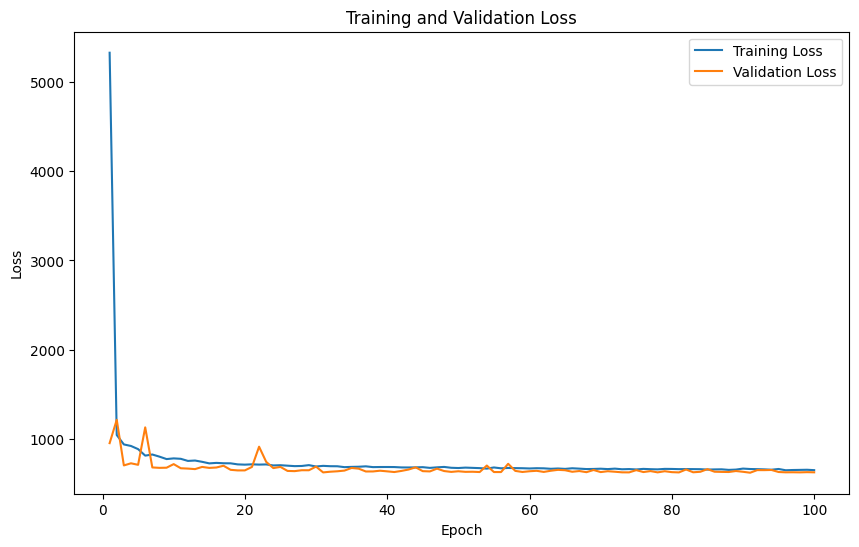

In [59]:
plt.figure(figsize=(10, 6))

train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1) 

plt.plot(epochs, train_loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")

plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [60]:
y_pred = model.predict(X_test)
y_pred[:10]

297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


array([[55.87014 ],
       [47.20407 ],
       [66.44574 ],
       [53.745117],
       [85.033844],
       [49.24621 ],
       [91.52    ],
       [77.467636],
       [46.798126],
       [57.897545]], dtype=float32)

In [61]:
y_pred.shape

(9504, 1)

In [62]:
y_test_df = pd.DataFrame({'Actual_Value': y_test.values})
y_pred_df = pd.DataFrame({'Predicted_Value': y_pred.flatten()})
result_df = pd.concat([y_test_df, y_pred_df], axis=1)
result_df


,Actual_Value,Predicted_Value
0,61.440,55.870
1,48.410,47.204
2,59.520,66.446
3,48.190,53.745
4,60.870,85.034
...,...,...
9499,52.090,85.300
9500,55.610,60.437
9501,89.770,74.009
9502,77.880,56.146


In [63]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)

578.6941499960956

In [64]:
model.evaluate(X_test, y_test)

297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 642.2966


578.6942138671875